In [1]:
# step 1
import time, os, sys
from data import process_file, build_vocab, read_category, read_vocab, batch_iter_v2, read_file
from datetime import timedelta
from self_attention_model_v2 import Config, SelfAttentionModel
import tensorflow as tf
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#from scipy.special import softmax
from gensim.models import KeyedVectors

In [2]:
# step 2 defines the file path
date_time = '20190730'
data_path = './data/Organization-Names-Corpus.txt'

base_dir = './data/2019-07-19'
train_dir = os.path.join(base_dir, 'train.txt')
test_dir = os.path.join(base_dir, 'test.txt')
val_dir = os.path.join(base_dir, 'val.txt')
vocab_dir = os.path.join(base_dir, 'vocab.txt')

save_dir = './result/checkpoints/'
save_dir = os.path.join(save_dir, date_time)
save_path = os.path.join(save_dir, 'best_validation')

In [3]:
# step 3 defines some functions which may need to be used later on
def get_time_dif(start_time):
    end_time = time.time()
    time_dif = end_time - start_time
    return timedelta(seconds=int(round(time_dif)))


def feed_data(x_batch, y_batch, keep_prob):
    feed_dict = {
        model.input_x: x_batch,
        model.input_y: y_batch,
        model.keep_prob: keep_prob
    }

    return feed_dict

def evaluate(sess, x_, y_):
    data_len = len(x_)
    batch_eval = batch_iter_v2(x_, y_, 128)

    total_loss = 0.0
    total_acc = 0.0

    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        feed_dict = feed_data(x_batch, y_batch, 1.0)
        loss, acc = sess.run([model.loss, model.acc], feed_dict=feed_dict)
        total_loss += loss * batch_len
        total_acc += acc * batch_len

    return total_loss / data_len, total_acc / data_len


def get_att_emb():
    print("Loading data...")
    start_time = time.time()
    # preprocess contents with padding seq and categorizing the label
    x, y = process_file(test_dir, word2id, cat2id, config.seq_length)

    etts, _ = read_file(test_dir)
    
    # restore the model from the saved file
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess=session, save_path=save_path)

    print("Getting self-attention and entity embedding...")
    atts, embs = [], []
    
    # get attentions/entity embeddings/character embedding by batch
    batch_data = batch_iter_v2(x, y, config.batch_size)
    for x_batch, y_batch in batch_data:
        #print(x_batch[0])
        feed_dict = feed_data(x_batch, y_batch, 1.0)
        att, emb, char_emb = session.run([model.att, model.entity_embs, model.embedding], feed_dict=feed_dict)
        atts.extend(att)
        embs.extend(emb)

    time_dif = get_time_dif(start_time)
    print("Time usage: ", time_dif)

    return atts, embs, etts, x, y, char_emb

In [4]:
# step 4 
print('Configuring self attention model...')
config = Config()
# build characters list by the occurance of characters
if not os.path.exists(vocab_dir):
    build_vocab(train_dir, vocab_dir, config.vocab_size)

categories, cat2id = read_category()
words, word2id = read_vocab(vocab_dir)
config.vocab_size = len(words)
model = SelfAttentionModel(config)

#attentions, embeddings, etts, padded_seq, char_embs = get_att_emb()
attentions, embeddings, etts, padded_seq, labels, char_embs = get_att_emb()
# print(attentions[:10])
# print(embeddings[:10])
# print(etts[:10])

Configuring self attention model...
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on bac

In [5]:
# step 5 generate mask using the shape of entities
atts = np.array(attentions)
s = atts.shape
atts = atts.reshape([s[0], s[2]])
mask = np.ma.make_mask(padded_seq)

In [6]:
# step 6 mask attentions to the length of each entity itself
masked_atts = []
sequences = []
for i, a in enumerate(atts):
    masked_atts.append(a[mask[i]])
    sequences.append(padded_seq[i][[mask[i]]])

d:\python\python35\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [8]:
entities = ["".join(e) for e in etts]


481317


In [35]:
from scipy.special import softmax
idx = entities.index('永磁同步发电机技术条件')
att = masked_atts[idx]
print(etts[idx])
print(masked_atts[idx])
print(softmax(1.5*att/np.sum(att)))

['永', '磁', '同', '步', '发', '电', '机', '技', '术', '条', '件']
[1.8805499e-13 1.8651085e-12 1.2601298e-11 1.2344756e-10 8.6672397e-10
 1.5400575e-08 3.6546828e-07 7.0318463e-05 4.4137156e-03 9.8899029e-02
 8.9661652e-01]
[0.07140529 0.07140529 0.07140529 0.07140529 0.07140529 0.07140529
 0.07140532 0.07141282 0.07187961 0.08282422 0.27404624]


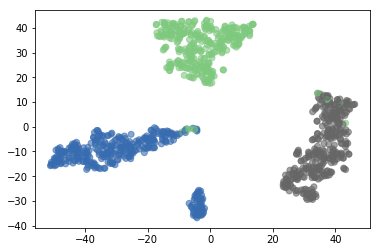

In [19]:
l = list(range(len(etts))) # example list
indices = random.sample(l, 1000)
tags = [np.argmax(l)for l in labels]
sub_tags = [tags[i] for i in indices]
sub_embs = [embeddings[i] for i in indices]
embs = np.array(sub_embs)
embs_trans = TSNE(n_components=2).fit_transform(embs)

data = np.insert(embs_trans, 2, values=sub_tags, axis=1)

x = data[:, 0]
y = data[:, 1]

plt.scatter(x, y, marker='o', c=data[:,2], cmap='Accent', alpha=0.6)
plt.show()

In [20]:
filename = 'embedding_data.npy'

np.save(filename,data)

In [19]:
# get entity embedding from trained char vectors
new_embs = []
for i, a in enumerate(masked_atts):
    cur_att = a/np.sum(a)
#     print(cur_att)
    cur_emb = np.zeros([128])
    for j, ch in enumerate(sequences[i]):
        cur_emb += cur_att[j] * char_embs[j]
    new_embs.append(cur_emb)
#new_embs = np.array(new_embs)

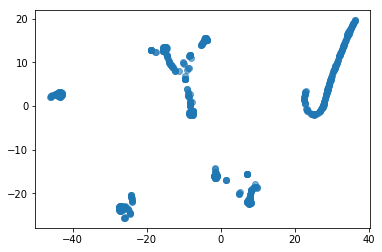

In [20]:
sub_embs = random.sample(new_embs, 500)
embs = np.array(sub_embs)
embs_trans = TSNE(n_components=2).fit_transform(embs)
x = embs_trans[:, 0]
y = embs_trans[:, 1]

plt.scatter(x, y, alpha=0.6)
plt.show()

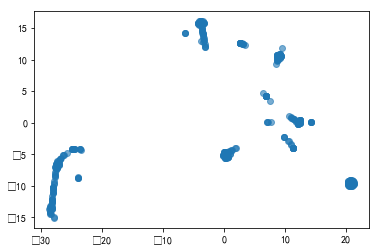

In [39]:
# draw T-SNE graph of entity_embedding generated from self-trained vectors
indices = random.sample(list(range(len(new_embs))), 300)
indices.sort()
sub_embs = []
names = []
for i in indices:
    sub_embs.append(new_embs[i])
    names.append(''.join(etts[i]))
    
embs = np.array(sub_embs)
embs_trans = TSNE(n_components=2).fit_transform(embs)
x = embs_trans[:, 0]
y = embs_trans[:, 1]

plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
plt.scatter(x, y, alpha=0.6)

# for i,txt in enumerate(names):
#     plt.annotate(txt,(x[i],y[i]))
plt.show()

In [ ]:
vec_file_name = 'test_data.vec'

f = open(vec_file_name, 'w', encoding='utf8')
f.write(str(len(etts)) + " " + '128' + '\n')

for i, e in enumerate(new_embs):
    line = "".join(etts[i])
    for num in e:
        line += " " + str(num)
    f.write(line+'\n')
        
f.close()

In [19]:
# step 7
def get_entity_vectors(filename=""):
    if len(filename) == 0:
        print("no file selected")
        exit(0)
    print("start loading word2vec from test_data ......")
    wv_from_text = KeyedVectors.load_word2vec_format(filename)
    print("word2vec load succeed!")
    
    return wv_from_text

In [20]:
# step 8
entity_model = get_entity_vectors('test_data_coef_1.5.vec')
# entity_model = get_entity_vectors('test_data.vec')

start loading word2vec from test_data ......
word2vec load succeed!


In [21]:
# step 9
entities = []
for e in entity_model.vocab:
    entities.append(e)

In [10]:
# step 10
e_vecs = entity_model.wv

d:\python\python35\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [40]:
# step 11
e_vecs.most_similar('中国航天科工集团公司第三研究院',topn=5)

[('中国航天科技集团公司第一研究院', 0.9914120435714722),
 ('中国航天工业总公司第一研究院', 0.980802059173584),
 ('中国航天科技集团第四研究院', 0.9793484210968018),
 ('中国航天科技集团公司总医院', 0.9594612121582031),
 ('航天第一研究院', 0.9484692215919495)]

In [30]:
# step 12
e_vecs.similarity('广饶县人民医院','丹阳书画院')

0.8980687

In [24]:
entities.index('中国航天科工集团公司第三研究院')

498070

In [23]:
a = entity_model.get_vector('快乐邀请')
b = entity_model.get_vector('声色邀请')

x = np.vstack((a, b))
np.cov(x)

array([[0.01161326, 0.01095722],
       [0.01095722, 0.01166413]])

In [ ]:
'''
2019-10-28
For each common entity, get the top N similar entities and save to a dict, and then store it to the file
'''
import json

n = 10
common_entities_file = './data/common_etts.txt'
json_file = './data/similar_etts.json'

common_etts = []
with open(common_entities_file, 'r', encoding='utf8') as f:
    for line in f:
        common_etts.append(line.strip())

simEtt_dict = dict()
for e in common_etts:
    simEtt_dict[e] = e_vecs.most_similar(e, topn=n)
    
# transfer dict into json and save into file
jsObj = json.dumps(simEtt_dict)
with open(json_file, 'w', encoding='utf8') as f:
    f.write(jsObj)

# # read from file and transfer json string into dict
# with open(json_file, 'r', encoding='utf8') as f:
#     jsObj = json.load(f)
#     ett_dict = json.loads(jsObj)

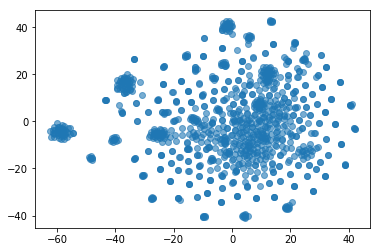

In [20]:
# draw T-SNE graph of entity_embedding generated from zh.vec
# clustering of entities
sub_etts = random.sample(entities, 1000)
sub_embs = []
for e in sub_etts:
    sub_embs.append(entity_model.get_vector(e))

embs = np.array(sub_embs)
embs_trans = TSNE(n_components=2).fit_transform(embs)

x = embs_trans[:, 0]
y = embs_trans[:, 1]

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.scatter(x, y, alpha=0.6)

for i,txt in enumerate(sub_etts):
    plt.annotate(txt,(x[i],y[i]))
plt.show()

In [22]:
filename = 'final_embedding.npy'

np.save(filename,embs_trans)

In [24]:
sub_etts


['养生先养心',
 '宝盖科技工业园',
 '邵严',
 '玫琳凯工作室',
 '科学技术100年',
 '音乐知识与欣赏',
 '山东大学威海分校商学院',
 '隋萍',
 '玉腊',
 '安徽省残疾人联合会',
 '宝鸡市渭滨中海大酒店',
 '吴开学',
 '群马帕斯大学',
 '女人平凡不平庸',
 '丽都皇冠假日酒店',
 '特殊的普通合伙企业',
 '哈里姆空军基地',
 '欧博士学堂',
 '马琴凤',
 '朗纳大学',
 '捉鬼小精灵',
 '权利的伦理基础',
 '梁佳玲',
 '蔡永其',
 '李树丰',
 '丹阳书画院',
 '于齐',
 '郴州市苏仙区司法局',
 '左右脑全脑开发',
 '教儿童彩笔画',
 '吕继春',
 '广东意隆不锈钢材料厂',
 '黄利芹',
 '王大洪',
 '江门三防指挥部',
 '药店执业药师手册',
 '呼玛县政府',
 '谢家小学',
 '大学城工商所',
 '鑫章烧腊店',
 '李昭民',
 '徐振高',
 '小米淘宝官方旗舰店',
 '彩德商场',
 '温州王朝国际大酒店',
 '郑远军',
 '菜用大豆',
 '企业管理咨询与诊断',
 '施能',
 '冬日阳光',
 '特克斯县二中',
 '北京市东直门中学',
 '王润秋',
 '清丰县公安局',
 '孙康宜',
 '水资源协会',
 '包升',
 '刘紫红',
 '恩施高中',
 '蔡菁',
 '绍兴佳源广场',
 '顾萌',
 '银色锁匙圈',
 '网络信息过滤原理与应用',
 '松花江大学',
 '宁泉',
 '阿亚亚',
 '牡丹江三中',
 '斯基之家',
 '石棉中学',
 '陵川科技局',
 '红岗区科学技术委员会',
 '阮昭',
 '人际关系与通用礼仪',
 '商丘电厂家属院',
 '教学实训基地',
 '二级基金',
 '叶开元',
 '耿某银行',
 '赵清学',
 '章敏',
 '韩柱',
 '设计管理与评估',
 '张惠龙',
 '刘会峰',
 '石清江',
 '库加图研究所',
 '贺燕燕',
 '中国保险报社',
 '清心园穆斯林饭庄',
 '杨宗易',
 '中国清代扬州画派研究会',
 '高世雄',
 '长兴实验幼儿园',
 '陈四龙',
 '曾立云',
 '开封市盐业管理局',
 '李兆麟将军纪念馆',
 '汪彦

In [ ]:
# get entity embedding from fasttext file: zh.vec
def get_vocab_vectors(filename=""):
    if len(filename) == 0:
        print("no file selected")
        exit(0)
    print("start loading word2vec from fasttext ......")
    wv_from_text = KeyedVectors.load_word2vec_format(filename)
    print("word2vec load succeed!")
    
    return wv_from_text

zh_model = get_vocab_vectors('../zh.vec')

In [ ]:
words = []
for word in zh_model.vocab:
    words.append(word)

In [ ]:
'''
Generate the entity embedding ------ version 1
use all fasttext word embedding model
1. use softmax to smooth the attention distribution
2. generate combined entity embeddings by adding the weighted vectors up
'''
from scipy.special import softmax

new_embs = []
for i, a in enumerate(masked_atts):
    cur_att = softmax(4*a/np.sum(a))
    if(i == 0): #
        print(cur_att)#
        break#
    cur_emb = np.zeros([300])
    discard = 0
    for j, ch in enumerate(etts[i]):
        if ch in word2id:
            if ch in words:
                cur_emb += cur_att[j - discard] * zh_model.get_vector(ch)
            else:
                cur_emb += cur_att[j - discard] * zh_model.get_vector('UNK')
        else:
            discard += 1
    new_embs.append(cur_emb)

In [ ]:
'''
Generate the entity embedding ------ version 1
Write the vectors into file
test_daa_v2.vec contains the vectors of masked attentions, with the sum of each element is 1. 
'''
vec_file_name = 'test_data_v2.vec'

f = open(vec_file_name, 'w')
f.write(str(len(etts)) + " " + '300' + '\n')

for i, e in enumerate(new_embs):
    line = "".join(etts[i])
    for num in e:
        line += " " + str(num)
    f.write(line+'\n')
        
f.close()

In [ ]:
'''
Generate the entity embedding ------ version 2
extract characters and corresponding vectors from fasttext word vectors
'''
filepath = '../characters.txt'
vecs = []
with open(filepath, 'w', encoding='utf8') as f:
    for w in words:
        if len(w) == 1 or w == 'UNK':
            vecs.append(zh_model.get_vector(w))
            f.write(w+'\n')
            
vec_file = '../vectors.npy'
np.save(vec_file, vecs)

#check whether has mismatch problem
vecs= np.load(vec_file)
characters = []
with open(filepath, 'r', encoding='utf8') as f:
    for line in f:
        characters.append(line.strip())
        
for i,c in enumerate(characters):
    if not (vecs[i] == zh_model.get_vector(c)).all():
        print(c + 'not match')
        break

In [ ]:
'''
Generate the entity embedding ------ version 2
generate the dict of (character, embedding)
'''
vec_file = '../vectors.npy'
ch_file = '../characters.txt'
vecs = np.load(vec_file)
characters = []
with open(ch_file, 'r', encoding='utf8') as f:
    for line in f:
        characters.append(line.strip())

vec_dict = dict(zip(characters,vecs))

In [ ]:
vec_dict['UNK']

In [ ]:
'''
Generate the entity embedding ------ version 2
use extracted fasttext characters embeddings
1. use softmax to smooth the attention distribution
2. generate combined entity embeddings by adding the weighted vectors up
'''
from scipy.special import softmax

new_embs = []
for i, a in enumerate(masked_atts):
    cur_att = softmax(1.5*a/np.sum(a))
#     if(i == 0): #
#         print(cur_att)#
#         break#
    cur_emb = np.zeros([300])
    discard = 0
    for j, ch in enumerate(etts[i]):
        if ch in word2id:
            if ch in characters:
                cur_emb += cur_att[j - discard] * vec_dict[ch]
            else:
                cur_emb += cur_att[j - discard] * vec_dict['UNK']
        else:
            discard += 1
    new_embs.append(cur_emb)

In [ ]:
'''
Write the vectors into file
test_data_v2.vec contains the vectors of masked attentions, with the sum of each element is 1. 
'''
vec_file_name = 'test_data_coef_1.5.vec'

f = open(vec_file_name, 'w', encoding='utf8')
f.write(str(len(etts)) + " " + '300' + '\n')

for i, e in enumerate(new_embs):
    line = "".join(etts[i])
    for num in e:
        line += " " + str(num)
    f.write(line+'\n')
        
f.close()

In [10]:
'''
step 10
#    Execute after step 9
Use entities with complete triplets to generate the potential relations or attributes for entities with incomplete triplets.
Method 1: Use multi entities to get the potential relations or attributes
'''

common_entities_file = './data/common_etts.txt'

common_etts = []
with open(common_entities_file, 'r', encoding='utf8') as f:
    for line in f:
        common_etts.append(line.strip())
        
common_etts_set = set(common_etts)
        
new_etts = [e for e in entities if e not in common_etts_set]

In [11]:
'''
save common_etts with their correspoding embedding into '.vec' file
'''
# extract common ett embedding from entity_model
common_etts_embs = [entity_model.get_vector(w) for w in common_etts]

common_etts_embs_file_name = './data/common_etts_embs_coef_1.5.vec'

# write embedding into file
f = open(common_etts_embs_file_name, 'w', encoding='utf8')
f.write(str(len(common_etts)) + " " + '300' + '\n')

for i, e in enumerate(common_etts_embs):
    line = "".join(common_etts[i])
    for num in e:
        line += " " + str(num)
    f.write(line+'\n')
        
f.close()

In [43]:
'''
time: 2019-10-30
# pre_require: entity_model from step 10
generate a random N sized slice from "new_etts" and add this list and corresponding embedding list to the common_etts_model,
and we can get topN similar entites of these sliced new_etts
'''
import random

N = 15
common_etts_embs_file_name = './data/common_etts_embs_coef_1.5.vec'

new_etts_slice = random.sample(new_etts, N)
new_etts_slice_embs = []
for e in new_etts_slice:
    new_etts_slice_embs.append(entity_model.get_vector(e))

# get common_etts' model from the file
common_etts_model = get_entity_vectors(common_etts_embs_file_name)
# add list and its embeddings into the model
common_etts_model.add(new_etts_slice, new_etts_slice_embs, replace=True)
common_vecs = common_etts_model.wv

for e in new_etts_slice:
    print(e)
    print(common_vecs.most_similar(e, topn = 10))

start loading word2vec from test_data ......
word2vec load succeed!
大庆精神铁人精神
[('大学的精神', 0.9465577006340027), ('天津精神', 0.9278537631034851), ('骑士精神', 0.9232873916625977), ('职业精神', 0.9172914028167725), ('重建文学的审美精神', 0.8912538290023804), ('蚂蚁精神', 0.8887314796447754), ('太古剑神', 0.8842256665229797), ('太阳女神', 0.8811620473861694), ('上古大神', 0.8753291368484497), ('武神', 0.8723615407943726)]
爱在仙境的日子
[('我的日子', 0.9298141598701477), ('和女神在一起的日子', 0.9196823835372925), ('尘封的日子', 0.9100114107131958), ('神剑好小子', 0.90920090675354), ('好日子', 0.9084675312042236), ('大地之子', 0.9082599878311157), ('和女主播同居的日子', 0.9051878452301025), ('安德的影子', 0.9007096290588379), ('爱情的房子', 0.899968683719635), ('唐人街小子', 0.8989108800888062)]
武士强
[('王中强', 0.9419100284576416), ('田强', 0.9405877590179443), ('王富强', 0.940380334854126), ('王志强', 0.9391060471534729), ('肖强', 0.9385333061218262), ('李德强', 0.9381874799728394), ('孔强', 0.9381373524665833), ('李大强', 0.9380433559417725), ('朱文强', 0.9379990100860596), ('王忠强', 0.9375113248825073)]
褚雪峰
[('

d:\python\python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [44]:
import json
triplets_json_file = './data/triplets.json'

def ER_matrix(top_similar_list):
    n = len(top_similar_list)
    relations = set()
    with open(triplets_json_file, 'r', encoding='utf8') as f:
        jsObj = json.load(f)
    
    for t in top_similar_list:
        print(t[0], jsObj[t[0]].keys())
        relations = relations.union(set(jsObj[t[0]].keys()))
    
    relation_list = list(relations)
    m = len(relation_list)
    
    er_matrix = np.zeros((n, m))
    for i, t in enumerate(top_similar_list):
        for j, r in enumerate(relation_list):
            if r in jsObj[t[0]].keys():
                er_matrix[i][j] = 1
    
    return relation_list, er_matrix

In [46]:
e = '大庆精神铁人精神'
top_similar_list = common_vecs.most_similar(e, topn = 10)
relation_list,er_matrix = ER_matrix(top_similar_list)



大学的精神 dict_keys(['explanation', '描述'])
天津精神 dict_keys(['概述', '信念', '中文名', 'explanation', '来源'])
骑士精神 dict_keys(['explanation', '外文名', '标签', '象征', '开创', '中文名', '描述', '来源'])
职业精神 dict_keys(['特点', 'explanation', '具有条件', '标签', '外文名', '包括', '中文名', '描述'])
重建文学的审美精神 dict_keys(['出版时间', 'ISBN', '标签', '作者', '出版社', '开本', '定价', '书名', '描述'])
蚂蚁精神 dict_keys(['出版时间', '页数', 'explanation', 'ISBN', '标签', '作者', '出版社', '定价', '装帧', '描述'])
太古剑神 dict_keys(['连载状态', 'explanation', '类型', '标签', '中文名称', '作者', '是否出版', '描述', '连载平台'])
太阳女神 dict_keys(['explanation', '描述'])
上古大神 dict_keys(['explanation', '标签', '作者', '中文名', '描述', '小说进度', '连载网站'])
武神 dict_keys(['总推荐', '连载状态', '中文名称', 'explanation', '类型', '标签', '主要角色', '作者', '描述', '总字数', '连载平台'])


In [47]:
print(er_matrix)
print(np.sum(er_matrix, axis=1))
print(np.sum(er_matrix, axis=0))
print(relation_list,len(relation_list))

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
  0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  1. 1. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
  1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 

['页数',
 '定义',
 '装帧',
 '定价',
 '地理位置',
 '描述',
 '出版时间',
 '性质',
 'explanation',
 '类型',
 '注音',
 '地址',
 '时间',
 'ISBN',
 '成立时间',
 '作者',
 '馆长',
 '中文名',
 '定编',
 '内设机构',
 '所属地区',
 '地点',
 '出版社',
 '馆藏档案',
 '标签',
 '书名']